In [1]:
import pandas as pd
import pymysql
from sqlalchemy import create_engine
import numpy as np
from dotenv import load_dotenv
import os

## Adatok lematizálása és adatbázisba mentése

In [2]:
load_dotenv()
DATABASE_URL = os.getenv("DATABASE_URL")
engine = create_engine(DATABASE_URL)

df = pd.read_sql("SELECT * FROM articles WHERE lemmatized_text is NULL ", con=engine)


In [3]:
from bs4 import BeautifulSoup

df['summary'] = df['summary'].apply(lambda x: BeautifulSoup(str(x), 'html.parser').get_text())

In [4]:
df['text'] = df['title'] + ' ' + df['summary']

In [5]:
df

,id,title,summary,lemmatized_text,link,category,predicted_category,published,text
0,29502,"Hatalmas botrány tört ki Csehországban, a korm...","Az Andrej Babiš volt kormányfő vezette, jelenl...",None,https://www.portfolio.hu/global/20250603/hatal...,Globál,None,2025-06-03 13:24:00,"Hatalmas botrány tört ki Csehországban, a korm..."
1,29503,"Szupercella: felkészülhet a Balaton, baljós té...",Ausztria felől érkező szupercella érte el az M...,None,https://www.portfolio.hu/gazdasag/20250603/szu...,Gazdaság,None,2025-06-03 13:12:00,"Szupercella: felkészülhet a Balaton, baljós té..."
2,29504,"Megtalálták a megoldást, így menekülhet meg a ...",A szakemberek folyamatosan figyelik a fejlemén...,None,https://index.hu/kulfold/2025/06/03/parajd-sob...,Külföld,None,2025-06-03 13:44:00,"Megtalálták a megoldást, így menekülhet meg a ..."
3,29505,Azonnali egyeztetést követel a kormány és a fő...,"A Liga Szakszervezetek elárulták, mitől félnek...",None,https://index.hu/belfold/2025/06/03/budapest-i...,Belföld,None,2025-06-03 13:43:00,Azonnali egyeztetést követel a kormány és a fő...
4,29506,"Szabalenka és Swiatek sem került bajba, összej...",A két klasszis különösebb probléma nélkül juto...,None,https://index.hu/sport/tenisz/2025/06/03/rolan...,Tenisz,None,2025-06-03 13:40:00,"Szabalenka és Swiatek sem került bajba, összej..."
...,...,...,...,...,...,...,...,...,...
713,30215,"Böde Dániel csak egy barátját látogatta meg, d...","Ismét kiderült, hatalmas a szíve a magyar gólk...",None,https://www.borsonline.hu/foci/2025/06/bode-da...,foci,None,2025-06-04 18:15:00,"Böde Dániel csak egy barátját látogatta meg, d..."
714,30216,„Egy 8 éves kislány halála megrendíti az ember...,Bánki Frigyes ipari búvár maga is részt vett a...,None,https://www.borsonline.hu/igaz-tortenetek/2025...,igaz-tortenetek,None,2025-06-04 18:00:00,„Egy 8 éves kislány halála megrendíti az ember...
715,30217,Ettől mindenki elolvad: elbűvölő fotót mutatot...,A rajongóit is elvarázsolta ez az édes kép.,None,https://www.borsonline.hu/magyar-sztarhirek/20...,magyar-sztarhirek,None,2025-06-04 17:50:00,Ettől mindenki elolvad: elbűvölő fotót mutatot...
716,30218,Figyelmeztetés! G4-es geomágneses vihar érte e...,"Rosszabb, mint a napszúrás.",None,https://www.borsonline.hu/igaz-tortenetek/2025...,igaz-tortenetek,None,2025-06-04 17:45:00,Figyelmeztetés! G4-es geomágneses vihar érte e...


In [6]:
import huspacy
import spacy

huspacy.download()
nlp = spacy.load("hu_core_news_lg")

['C:\\Users\\KomPhone\\projects\\ml\\cubix_ml_vizsga\\.venv\\Scripts\\python.exe', '-m', 'pip', 'install', 'hu_core_news_lg @ https://huggingface.co/huspacy/hu_core_news_lg/resolve/v3.8.0/hu_core_news_lg-any-py3-none-any.whl']


In [7]:
def lemmatize(text):
    doc = nlp(text.lower())
    return ' '.join(
        token.lemma_ for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    )

df['lemmatized_text'] = df['text'].apply(lemmatize)


In [8]:
from sqlalchemy.orm import Session
from app.db.database import SessionLocal
import app.models as models

db: Session = SessionLocal()

articles_to_update = (
    db.query(models.Articles)
    .filter(models.Articles.lemmatized_text.is_(None))
    .all()
)

lemmatized_map = dict(zip(df['link'], df['lemmatized_text']))

for article in articles_to_update:
    if article.link in lemmatized_map:
        article.lemmatized_text = lemmatized_map[article.link]

db.commit()
db.close()

## Kategoriák előkészítése

In [9]:
df = pd.read_sql("SELECT * FROM articles", con=engine)

In [10]:
df

,id,title,summary,lemmatized_text,link,category,predicted_category,published
0,1,Satuba fogták a forintot,"Hétfőn egy enyhe erősödéssel zárt a forint, bá...",satu fog forint hétfő enyhe erősödés zár forin...,https://www.portfolio.hu/deviza/20250603/satub...,Deviza,None,2025-06-03 08:30:00
1,2,Visszadobta Zelenszkij az orosz békefeltételek...,Tegnap béketárgyalást folytatott Oroszország é...,visszadob zelenszkij orosz békefeltétel botrán...,https://www.portfolio.hu/global/20250603/vissz...,Globál,None,2025-06-03 08:25:00
2,3,Nyilatkozott a béketárgyalásokról Oroszország ...,"Telegram fiókján nyilatkozott a tegnapi, siker...",nyilatkozik béketárgyalás oroszország erős emb...,https://www.portfolio.hu/global/20250603/nyila...,Globál,None,2025-06-03 08:25:00
3,4,Sínre tették von der Leyen újabb százmilliárdo...,"Jó úton haladnak afelé, hogy még az év vége el...",sín tesz von der ley százmilliárdos keleti ügy...,https://www.portfolio.hu/unios-forrasok/202506...,Uniós források,None,2025-06-03 08:22:00
4,5,Itt a friss előrejelzés: idén alig növekedhet ...,Az OECD friss előrejelzése szerint a magyar ga...,friss előrejelzés idén alig növekedhet magyar ...,https://www.portfolio.hu/gazdasag/20250603/itt...,Gazdaság,None,2025-06-03 08:09:00
...,...,...,...,...,...,...,...,...
30214,30215,"Böde Dániel csak egy barátját látogatta meg, d...","Ismét kiderült, hatalmas a szíve a magyar gólk...",böde dániel barát látogat számít kiderül hatal...,https://www.borsonline.hu/foci/2025/06/bode-da...,foci,None,2025-06-04 18:15:00
30215,30216,„Egy 8 éves kislány halála megrendíti az ember...,Bánki Frigyes ipari búvár maga is részt vett a...,éves kislány halál megrendít ember megszólal h...,https://www.borsonline.hu/igaz-tortenetek/2025...,igaz-tortenetek,None,2025-06-04 18:00:00
30216,30217,Ettől mindenki elolvad: elbűvölő fotót mutatot...,A rajongóit is elvarázsolta ez az édes kép.,ez elolvad elbűvölő fotó mutat rácz jenő feles...,https://www.borsonline.hu/magyar-sztarhirek/20...,magyar-sztarhirek,None,2025-06-04 17:50:00
30217,30218,Figyelmeztetés! G4-es geomágneses vihar érte e...,"Rosszabb, mint a napszúrás.",figyelmeztetés geomágneses vihar ér bolygó bru...,https://www.borsonline.hu/igaz-tortenetek/2025...,igaz-tortenetek,None,2025-06-04 17:45:00


In [11]:
df.drop([
    "id",
    "predicted_category",
    "published",
    "link"
], axis=1, inplace=True)

In [12]:
import unicodedata

def remove_accents(text):
    if isinstance(text, str):
        nfkd_form = unicodedata.normalize('NFKD', text)
        return ''.join([c for c in nfkd_form if not unicodedata.combining(c)]).lower()
    return text

df['category'] = df['category'].apply(remove_accents)

In [13]:
df.dropna(inplace=True)

### Kategoriák összevonása

In [14]:
df['category'] = df['category'].replace({
    'global': 'kulfold',
    'hirtvkulfold': 'kulfold',
    'kulpol': 'kulfold',
    'nagyvilag': 'kulfold',
    'vilag': 'kulfold',
    'celeb': 'bulvar',
    'sztarok': 'bulvar',
    'sztarvilag': 'bulvar',
    'kultur': 'kultura',
    'teve': 'bulvar',
    'techtud': 'tudomany',
    'techbazis': 'tudomany',
    'tech-tudomany': 'tudomany',
    'tech': 'tudomany',
    'itthon': 'belfold',
    'belpol': 'belfold',
    'politika': 'belfold',
    'nemzetkozi-gazdasag': 'gazdasag',
    'uzlet': 'gazdasag',
    'penz': 'gazdasag',
    'bank': 'gazdasag',
    'befektetes': 'gazdasag',
    'deviza': 'gazdasag',
    'vilaggazdasag-magyar-gazdasag': 'gazdasag',
    'elet-stilus': 'eletmod',
    'ferfiaknak': 'eletmod',
    'test-es-lelek': 'eletmod',
    'bunugyek': 'baleset-bunugy',
    'futball': 'sport',
    'foci': 'sport',
    'szorakozas': 'bulvar',
})

### Kategoriák eltávolítása
Értelmetlen valós információt nem tartalmazó kategoriák letávolítása

In [15]:
df = df[~df['category'].isin(['2023', 'hirek', 'hirado', 'aktualis', 'mindekozben'])]

Kategoriák szűrése

In [16]:
category_counts = df['category'].value_counts()

valid_categories = category_counts[category_counts >= 300].index

df = df[df['category'].isin(valid_categories)]


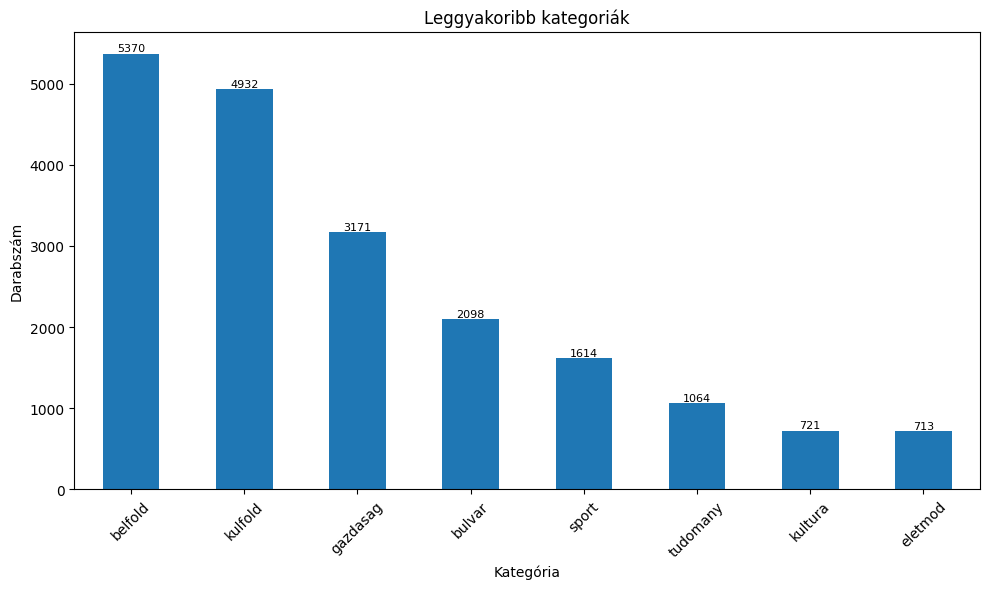

In [17]:
import matplotlib.pyplot as plt

top_categories = df['category'].value_counts().nlargest(20)

plt.figure(figsize=(10, 6))
ax = top_categories.plot(kind='bar')

plt.title('Leggyakoribb kategoriák')
plt.xlabel('Kategória')
plt.ylabel('Darabszám')
plt.xticks(rotation=45)
plt.tight_layout()

for i, value in enumerate(top_categories.values):
    ax.text(i, value + 5, str(value), ha='center', va='bottom', fontsize=8)

plt.show()

In [18]:
df

,title,summary,lemmatized_text,category
0,Satuba fogták a forintot,"Hétfőn egy enyhe erősödéssel zárt a forint, bá...",satu fog forint hétfő enyhe erősödés zár forin...,gazdasag
1,Visszadobta Zelenszkij az orosz békefeltételek...,Tegnap béketárgyalást folytatott Oroszország é...,visszadob zelenszkij orosz békefeltétel botrán...,kulfold
2,Nyilatkozott a béketárgyalásokról Oroszország ...,"Telegram fiókján nyilatkozott a tegnapi, siker...",nyilatkozik béketárgyalás oroszország erős emb...,kulfold
4,Itt a friss előrejelzés: idén alig növekedhet ...,Az OECD friss előrejelzése szerint a magyar ga...,friss előrejelzés idén alig növekedhet magyar ...,gazdasag
5,Megnevezték az oroszok a bombázóflottát megbén...,Egy Artyom Timofejev nevű ukrán férfit gyanúsí...,megnevez orosz bombázóflotta megbénító támadás...,kulfold
...,...,...,...,...
30175,Örömhír: leküzdötte a rákot és apa lesz sokak ...,A gólyahírt a büszke apuka osztotta meg a közö...,örömhír leküzdöt rák apa sok kedvenc futballis...,sport
30183,Szoboszlai leendő csapattársa széttaposta a Pr...,Florian Wirtz a gólja mellett mással is felhív...,szoboszlai leendő csapattárs széttapos premier...,sport
30190,"""A bíró nem tudja a szabályokat"" - kiakadt a p...",Cristiano Ronaldo emlékezetessé tette a 220. v...,bíró tud szabály kiakad portugál sztár végül c...,sport
30199,"Szoboszlai sehol sincs, csúcsfizetéssel várják...",Florian Wirtz a legdrágábban eladott német foc...,szoboszlai sehol sincs csúcsfizetés vár liverp...,sport


## Kategoria predikció XGBoost-tel

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
df['combined'] = df['summary'] + ' ' + df['lemmatized_text']
X = vectorizer.fit_transform(df['combined'])

In [20]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(df['category'])


In [21]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

classes = np.unique(y)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
weight_dict = dict(zip(classes, class_weights))

# Minden sorhoz hozzárendeljük a megfelelő súlyt
sample_weights = np.array([weight_dict[label] for label in y])


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, sample_weights, test_size=0.2, stratify=y, random_state=42
)


In [23]:
import optuna
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': len(np.unique(y_train)),
        'eval_metric': 'mlogloss',
        'n_jobs': -1,
        'verbosity': 0,
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        'gamma': trial.suggest_int('gamma', 0, 10)
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train, sample_weight=w_train)

    y_pred = model.predict(X_test)
    return f1_score(y_test, y_pred, average='macro')


C:\Users\KomPhone\projects\ml\cubix_ml_vizsga\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)  # 10


[I 2025-06-05 11:04:54,447] A new study created in memory with name: no-name-1019fbde-8338-4260-b083-b8219cff9b0e
[I 2025-06-05 11:06:04,579] Trial 0 finished with value: 0.6730714207753334 and parameters: {'n_estimators': 345, 'max_depth': 6, 'learning_rate': 0.04870735780593688, 'subsample': 0.8754802867481496, 'colsample_bytree': 0.8551655957225699, 'gamma': 1}. Best is trial 0 with value: 0.6730714207753334.
[I 2025-06-05 11:06:21,320] Trial 1 finished with value: 0.6535746504240465 and parameters: {'n_estimators': 159, 'max_depth': 7, 'learning_rate': 0.20891072939727873, 'subsample': 0.7900393721987048, 'colsample_bytree': 0.8322873032257015, 'gamma': 9}. Best is trial 0 with value: 0.6730714207753334.


In [25]:
# study.stop()

In [26]:
print("Best trial:")
print("  Value (macro F1):", study.best_value)
print("  Params:", study.best_params)

Best trial:
  Value (macro F1): 0.6730714207753334
  Params: {'n_estimators': 345, 'max_depth': 6, 'learning_rate': 0.04870735780593688, 'subsample': 0.8754802867481496, 'colsample_bytree': 0.8551655957225699, 'gamma': 1}


In [27]:
best_model = XGBClassifier(
    **study.best_params,
    objective='multi:softmax',
    num_class=len(np.unique(y_train)),
    eval_metric='mlogloss',
    n_jobs=-1
)

best_model.fit(X_train, y_train, sample_weight=w_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8551655957225699, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, feature_weights=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.04870735780593688,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=345, n_jobs=-1, num_class=8, ...)

In [28]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

     belfold       0.73      0.68      0.71      1074
      bulvar       0.72      0.74      0.73       420
     eletmod       0.55      0.58      0.56       143
    gazdasag       0.70      0.70      0.70       634
     kulfold       0.79      0.70      0.74       986
     kultura       0.53      0.62      0.57       144
       sport       0.88      0.85      0.87       323
    tudomany       0.41      0.69      0.51       213

    accuracy                           0.70      3937
   macro avg       0.66      0.69      0.67      3937
weighted avg       0.72      0.70      0.71      3937



In [29]:
import joblib
joblib.dump(best_model, "xgboost_best_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [30]:
def predict_category(text: str) -> str:
    text_clean = (lemmatize(text)).lower()
    X = vectorizer.transform([text_clean])
    pred = best_model.predict(X)
    return le.inverse_transform(pred)[0]


In [31]:
predict_category('A női energia aktiválása! 4 gyakorlat, hogy újra kapcsolódj a feminin énedhez')

'sport'

## Kategória predikció Neurális hálóval-val

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout


vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['combined'])

le = LabelEncoder()
y = le.fit_transform(df['category'])
y_cat = to_categorical(y)

# 3. Tanító és teszt halmaz
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, stratify=y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# 4. Súlyozás a kiegyensúlyozatlan osztályokhoz
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
weight_dict = dict(enumerate(class_weights))

# 5. Neurális háló modell
model = Sequential([
    Dense(64, activation='relu', input_shape=(X.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

# 6. Tanítás
model.fit(
    X_train.toarray(), y_train,
    validation_data=(X_val.toarray(), y_val),
    epochs=10,
    batch_size=64,
    class_weight=weight_dict,
    callbacks=[early_stop]
)

# 7. Értékelés
loss, acc = model.evaluate(X_test.toarray(), y_test)
print(f"Pontosság: {acc:.3f}")

Epoch 1/10
216/216 [==============================] - 2s 6ms/step - loss: 1.7517 - accuracy: 0.4766 - val_loss: 1.0869 - val_accuracy: 0.7148
Epoch 2/10
216/216 [==============================] - 1s 5ms/step - loss: 0.8803 - accuracy: 0.7439 - val_loss: 0.8170 - val_accuracy: 0.7378
Epoch 3/10
216/216 [==============================] - 1s 5ms/step - loss: 0.5476 - accuracy: 0.8213 - val_loss: 0.7477 - val_accuracy: 0.7517
Epoch 4/10
216/216 [==============================] - 1s 5ms/step - loss: 0.3739 - accuracy: 0.8718 - val_loss: 0.7554 - val_accuracy: 0.7520
Epoch 5/10
216/216 [==============================] - 1s 5ms/step - loss: 0.2650 - accuracy: 0.9014 - val_loss: 0.7894 - val_accuracy: 0.7490
Epoch 6/10
216/216 [==============================] - 1s 5ms/step - loss: 0.1980 - accuracy: 0.9216 - val_loss: 0.8405 - val_accuracy: 0.7453
Epoch 7/10
93/93 [==============================] - 0s 1ms/step - loss: 0.7118 - accuracy: 0.7623
Pontosság: 0.762


In [42]:
model.save("category_predicter.keras")

## Tesztelés

In [43]:
from tensorflow.keras.models import load_model
import pickle

model = load_model("models/text_classifier.keras")

with open("models/vectorizer.pkl", "rb") as f:
    vectorizer = pickle.load(f)


In [46]:
tester = pd.read_sql("SELECT * FROM articles WHERE lemmatized_text is NULL ", con=engine)

In [47]:
tester["text"] = tester["title"].fillna("") + " " + tester["summary"].fillna("")
tester['lemmatized_text'] = tester['text'].apply(lemmatize)

tester["combined"] = tester["text"] + " " + tester['lemmatized_text']
X_new = vectorizer.transform(tester["combined"])

In [48]:
y_pred = model.predict(X_new.toarray())
y_labels = np.argmax(y_pred, axis=1)
tester["predicted_category"] = le.inverse_transform(y_labels)

2/2 [==============================] - 0s 2ms/step


In [49]:
tester

,id,title,summary,lemmatized_text,link,category,predicted_category,published,text,combined
0,30220,Érik a nagy pofon a magyar kormánynak az Európ...,Az Európai Unió Bíróságának főtanácsnokának mo...,ér pofon magyar kormány európai unió bíróság e...,https://www.portfolio.hu/unios-forrasok/202506...,Uniós források,kulfold,2025-06-05 09:17:00,Érik a nagy pofon a magyar kormánynak az Európ...,Érik a nagy pofon a magyar kormánynak az Európ...
1,30221,"Leállt a Suzuki Swiftek gyártása - Elárulták, ...",A Suzuki Motor felfüggesztette Swift modelljén...,leáll suzuki swift gyártás elárul tesz kereszt...,https://www.portfolio.hu/uzlet/20250605/leallt...,Üzlet,kulfold,2025-06-05 09:15:00,"Leállt a Suzuki Swiftek gyártása - Elárulták, ...","Leállt a Suzuki Swiftek gyártása - Elárulták, ..."
2,30222,Videó: a legjobb nyugati fegyvereit vetette be...,Orosz források jelentése szerint újabb M1A1 Ab...,videó jó nyugati fegyver vet ukrajna orosz off...,https://www.portfolio.hu/global/20250605/video...,Globál,gazdasag,2025-06-05 09:05:00,Videó: a legjobb nyugati fegyvereit vetette be...,Videó: a legjobb nyugati fegyvereit vetette be...
3,30223,"Véglegesen gyógyíthatóvá válhat a halálos kór,...",Áttörést értek el ausztrál kutatók a HIV kezel...,végleges gyógyítható válhat halálos kór amely ...,https://www.portfolio.hu/gazdasag/20250605/veg...,Gazdaság,gazdasag,2025-06-05 09:00:00,"Véglegesen gyógyíthatóvá válhat a halálos kór,...","Véglegesen gyógyíthatóvá válhat a halálos kór,..."
4,30224,Határokat lépnek át és szabályok szegnek meg Ó...,"Három lány sétált a falujában, és világhírűek ...",határ lép szabály szeg óbuda három lány sétál ...,https://index.hu/kultur/2025/06/05/kobuci-kert...,Kultúr,kulfold,2025-06-05 09:20:00,Határokat lépnek át és szabályok szegnek meg Ó...,Határokat lépnek át és szabályok szegnek meg Ó...
5,30225,Bereczki Zoltán szerint hatalmas támadási felü...,"A művész nagyinterjút adott, amelyben megoszto...",bereczki zoltán hatalmas támadási felület közé...,https://index.hu/kultur/2025/06/05/bereczki-zo...,Kultúr,belfold,2025-06-05 09:15:00,Bereczki Zoltán szerint hatalmas támadási felü...,Bereczki Zoltán szerint hatalmas támadási felü...
6,30226,"Lecseréli a lábbilincseket a rendőrség, okosór...",Gyorsabb reagálást és diszkrétebb megjelenést ...,lecserél lábbilincs rendőrség okosóra lesz hel...,https://index.hu/belfold/2025/06/05/labbilincs...,Belföld,belfold,2025-06-05 09:09:00,"Lecseréli a lábbilincseket a rendőrség, okosór...","Lecseréli a lábbilincseket a rendőrség, okosór..."
7,30227,"Elképesztő szabályértelmezési hiba, jogtalanul...",Óriási balhé a dán kézilabda világában.,elképesztő szabályértelmezési hiba jogtalan in...,https://index.hu/sport/kezilabda/2025/06/05/ke...,Kézilabda,kulfold,2025-06-05 09:03:00,"Elképesztő szabályértelmezési hiba, jogtalanul...","Elképesztő szabályértelmezési hiba, jogtalanul..."
8,30228,Keményen helyretették az elszabadult „Tibi aty...,Tóth Máté korábban Szent Pál megtéréséhez haso...,kemény helyret elszabadult tibi atya ukrajna v...,https://mandiner.hu/belfold/2025/06/kemenyen-h...,belfold,kulfold,2025-06-05 09:20:08,Keményen helyretették az elszabadult „Tibi aty...,Keményen helyretették az elszabadult „Tibi aty...
9,30229,Takács Péter: Brüsszelben a háziorvosoknak is ...,Az egészségügyi államtitkár a jövőben kapuőri ...,takács péter brüsszel háziorvos árt egészségüg...,https://24.hu/belfold/2025/06/05/kormany-hazio...,Belföld,gazdasag,2025-06-05 09:17:15,Takács Péter: Brüsszelben a háziorvosoknak is ...,Takács Péter: Brüsszelben a háziorvosoknak is ...
